In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('titanic - titanic.csv')

In [3]:
# Display the first few rows and the structure of the dataset
print(data.head())
print(data.info())
print("Columns in the dataset:", data.columns.tolist())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [4]:
#Define target and features
target = 'Survived'   
features = data.columns.drop([target]).tolist()


In [5]:
# Split the data into features and target
X = data[features]
y = data[target]

In [6]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [7]:
# Preprocessing pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

 

In [8]:
# Function to evaluate logistic regression with cross-validation
def evaluate_logistic_regression(X, y):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])

    # Single train-test split evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    single_split_accuracy = accuracy_score(y_test, y_pred)
    single_split_precision = precision_score(y_test, y_pred)
    single_split_recall = recall_score(y_test, y_pred)
    single_split_f1 = f1_score(y_test, y_pred)
    
    # K-fold cross-validation evaluation
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    print(f"Single Split - Accuracy: {single_split_accuracy:.4f}, Precision: {single_split_precision:.4f}, Recall: {single_split_recall:.4f}, F1 Score: {single_split_f1:.4f}")
    print(f"Cross-Validation - Mean Accuracy: {cv_mean:.4f}, Std Accuracy: {cv_std:.4f}")
    
    return model

In [9]:
# Evaluate logistic regression with cross-validation
evaluate_logistic_regression(X, y)

Single Split - Accuracy: 0.8212, Precision: 0.8088, Recall: 0.7432, F1 Score: 0.7746
Cross-Validation - Mean Accuracy: 0.8136, Std Accuracy: 0.0489


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PassengerId', 'Pclass',
                                                   'Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Name', 'Sex', 'Ticket',
                                                   'Cabin', 'Embarked'])])),
                ('classifier', LogisticRegression(random_state=42))])

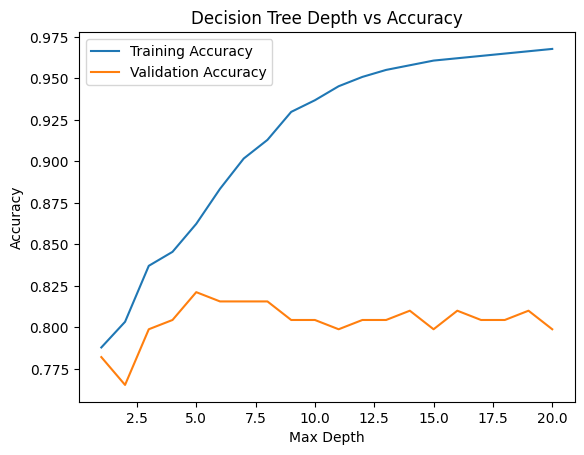

In [10]:
# Function to analyze overfitting and underfitting in decision trees
def analyze_decision_trees(X, y):
    max_depths = range(1, 21)
    train_accuracies = []
    val_accuracies = []

    for max_depth in max_depths:
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(max_depth=max_depth, random_state=42))
        ])
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        val_accuracies.append(accuracy_score(y_val, y_val_pred))
    
    plt.plot(max_depths, train_accuracies, label='Training Accuracy')
    plt.plot(max_depths, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Decision Tree Depth vs Accuracy')
    plt.show()

# Analyze overfitting and underfitting in decision trees
analyze_decision_trees(X, y)


In [11]:
# Function to calculate precision, recall, and F1-score for logistic regression
def logistic_regression_metrics(X, y):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

# Calculate precision, recall, and F1-score for logistic regression
logistic_regression_metrics(X, y)


Precision: 0.8088, Recall: 0.7432, F1 Score: 0.7746
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

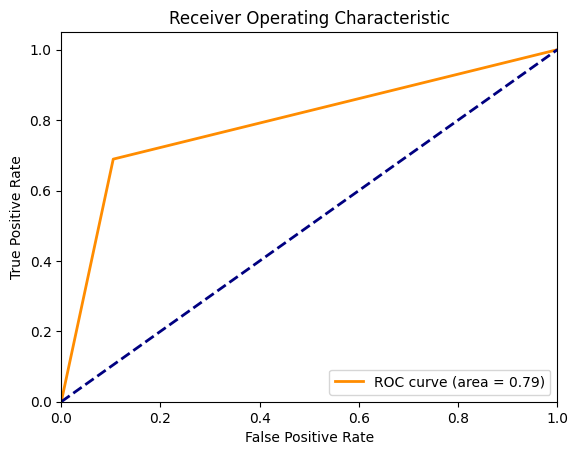

In [14]:
# Function to plot ROC curve and compute AUC for decision trees
def decision_tree_roc_analysis(X, y):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# ROC curve analysis for decision trees
decision_tree_roc_analysis(X, y)


In [15]:
# Function to compare logistic regression and decision tree models with and without cross-validation
def compare_models(X, y):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    
    for name, classifier in models.items():
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        single_split_accuracy = accuracy_score(y_test, y_pred)
        single_split_precision = precision_score(y_test, y_pred)
        single_split_recall = recall_score(y_test, y_pred)
        
        kf = KFold(n_splits=10, random_state=42, shuffle=True)
        cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)
        
        print(f"{name} - Single Split - Accuracy: {single_split_accuracy:.4f}, Precision: {single_split_precision:.4f}, Recall: {single_split_recall:.4f}")
        print(f"{name} - Cross-Validation - Mean Accuracy: {cv_mean:.4f}, Std Accuracy: {cv_std:.4f}")

# Compare model performance with and without cross-validation
compare_models(X, y)


Logistic Regression - Single Split - Accuracy: 0.8212, Precision: 0.8088, Recall: 0.7432
Logistic Regression - Cross-Validation - Mean Accuracy: 0.8136, Std Accuracy: 0.0489
Decision Tree - Single Split - Accuracy: 0.8101, Precision: 0.8226, Recall: 0.6892
Decision Tree - Cross-Validation - Mean Accuracy: 0.8238, Std Accuracy: 0.0418
